# Hypertuning Predictive Modeling of Customer Bookings

---

This project aims to analyze customer booking data to predict whether a booking will be completed. The process starts by preparing the dataset—irrelevant columns are dropped, and features are categorized into numerical and categorical types, which are then preprocessed through scaling and encoding. After preprocessing, we train two machine learning models: a neural network and an XGBoost classifier.

To find the best configurations for these models, hyperparameter tuning is conducted—using Keras Tuner for the neural network and RandomizedSearchCV for the XGBoost model. Both models are evaluated on a test set, and we also visualize feature importance to understand which features have the most influence on predictions. The project ends with visualizations of feature importance for both models, providing insights into the factors driving booking completion. This comprehensive approach helps improve our understanding of customer behavior and supports effective decision-making for optimizing booking strategies.

This script imports various essential libraries to preprocess data, train machine learning models, and perform analysis. It includes tools for splitting the dataset, scaling numerical features, and encoding categorical data using scikit-learn's preprocessing utilities. The imported TensorFlow and Keras libraries are used to build, train, and tune neural networks, while XGBoost is used for classification tasks. Additionally, RandomizedSearchCV and RandomSearch are used to optimize hyperparameters for both neural networks and other models. Visualization tools like matplotlib and data manipulation utilities like pandas and numpy are also imported for analysis and presentation.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner.tuners import RandomSearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [6]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [7]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

In [8]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In this section, the dataset is prepared for model training. Irrelevant columns are dropped, and the features (X) are separated from the target variable (y). The features are categorized into numerical and categorical types, and appropriate preprocessing steps are applied: numerical features are scaled using StandardScaler, and categorical features are one-hot encoded using OneHotEncoder. These preprocessing steps are combined using a ColumnTransformer and applied to the dataset. Finally, the preprocessed data is split into training and testing sets, and the resulting arrays are converted to DataFrames to retain feature names for easier interpretation and further analysis.

In [9]:
# Separate features and target variable
df.drop(columns=["route", "booking_origin"], inplace=True)
X = df.drop(columns=['booking_complete'], axis=1)
y = df['booking_complete']

# Identify categorical and numerical columns
categorical_features = ['sales_channel', 'trip_type', 'flight_day']
numerical_features = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration', 
                      'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline with preprocessing
X_prepared = preprocessor.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_prepared, y, test_size=0.2, random_state=42)

# Convert X_train and X_test to DataFrame to retain feature names
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
X_train = pd.DataFrame(X_train.toarray() if hasattr(X_train, 'toarray') else X_train, columns=feature_names)
X_test = pd.DataFrame(X_test.toarray() if hasattr(X_test, 'toarray') else X_test, columns=feature_names)

This section involves hyperparameter tuning for a neural network using Keras Tuner. The function build_model defines a neural network architecture where the number of units in each layer, the number of hidden layers, the dropout rate, and the learning rate are all tuned. A RandomSearch tuner is used to find the optimal combination of these hyperparameters, optimizing for validation accuracy. Once the optimal hyperparameters are identified, the model is trained with early stopping to avoid overfitting. Finally, the model's performance is evaluated on the test set to determine the best achieved accuracy.

In [10]:
# Hyperparameter tuning for Neural Network using Keras Tuner
def build_model(hp):
    model = Sequential()
    # Tune the number of units in the first Dense layer
    hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
    model.add(Dense(units=hp_units, activation='relu', input_shape=(X_train.shape[1],)))
    
    # Tune the number of hidden layers and units in each layer
    for i in range(hp.Int('num_layers', 1, 3)):
        hp_units_hidden = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        model.add(Dense(units=hp_units_hidden, activation='relu'))
        
        # Add dropout layer and tune the rate
        hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        model.add(Dropout(rate=hp_dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Number of different models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='tuner_results',
    project_name='nn_hyperparameter_tuning'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
best_model = tuner.hypermodel.build(best_hps)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = best_model.fit(X_train, y_train, epochs=20, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Best Neural Network Accuracy: {accuracy}')



Reloading Tuner from tuner_results\nn_hyperparameter_tuning\tuner0.json
Epoch 1/20


C:\Users\aryah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 811us/step - accuracy: 0.8459 - loss: 0.4318 - val_accuracy: 0.8515 - val_loss: 0.4108
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - accuracy: 0.8513 - loss: 0.4100 - val_accuracy: 0.8515 - val_loss: 0.4021
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.8492 - loss: 0.4116 - val_accuracy: 0.8515 - val_loss: 0.4078
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.8485 - loss: 0.4116 - val_accuracy: 0.8515 - val_loss: 0.4031
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.8496 - loss: 0.4072 - val_accuracy: 0.8515 - val_loss: 0.4051
Best Neural Network Accuracy: 0.8519999980926514


Feature importance for the trained neural network model is visualized by examining the weights of the first layer. The importance of each feature is calculated by taking the mean of the absolute values of the input layer weights. The top 10 most important features are identified and plotted in a horizontal bar chart, giving insight into which input variables most strongly influence the predictions of the neural network. This helps to interpret the model and understand which features contribute the most to the model's performance.

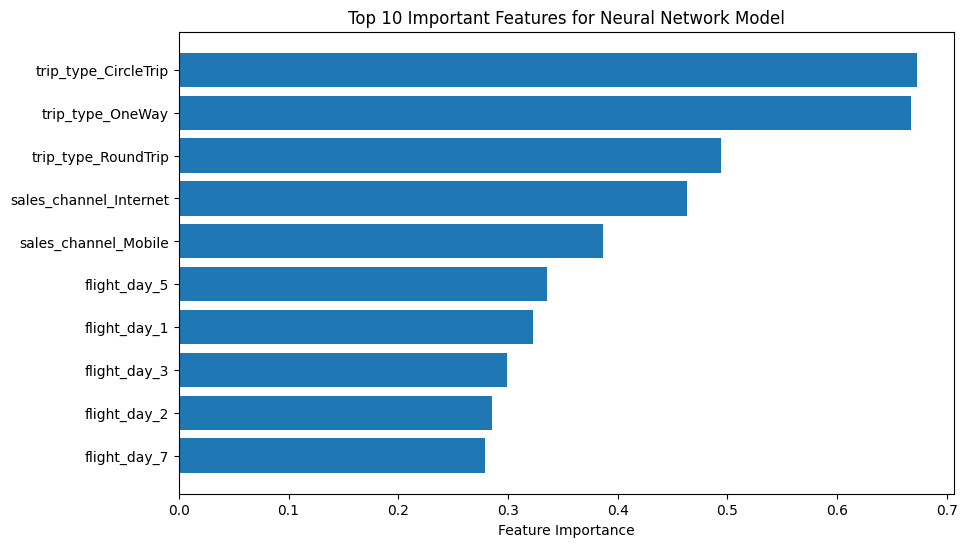

In [11]:
# Plot feature importance for Neural Network
# Extract feature importance from input weights (only applicable to first layer)
first_layer_weights = best_model.layers[0].get_weights()[0]
feature_importance_nn = np.mean(np.abs(first_layer_weights), axis=1)
sorted_idx_nn = np.argsort(feature_importance_nn)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_nn)), feature_importance_nn[sorted_idx_nn], align='center')
plt.yticks(range(len(sorted_idx_nn)), [X_train.columns[i] for i in sorted_idx_nn])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for Neural Network Model')
plt.gca().invert_yaxis()
plt.show()

Hyperparameter tuning is performed for the XGBoost model using RandomizedSearchCV to optimize performance. A grid of hyperparameters is defined, including parameters like the number of estimators, learning rate, and maximum tree depth. The RandomizedSearchCV function randomly samples from this grid to identify the best combination of hyperparameters, using a 3-fold cross-validation process and ROC AUC as the scoring metric. After finding the best parameters, the XGBoost model is trained on the training data and evaluated on the test set to determine its accuracy.

In [12]:
# Hyperparameter tuning for XGBoost using RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Initialize the XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings sampled
    scoring='roc_auc',  # Use AUC as the evaluation metric
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best parameters and the corresponding score
best_params = random_search.best_params_
print(f'Best XGBoost Parameters: {best_params}')

# Train the XGBoost model with the best parameters
best_xgb_model = random_search.best_estimator_

# Evaluate the model
accuracy = best_xgb_model.score(X_test, y_test)
print(f'Best XGBoost Accuracy: {accuracy}')

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 5, 'colsample_bytree': 0.8}
Best XGBoost Accuracy: 0.8518


C:\Users\aryah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:00:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Feature importance for the trained XGBoost model is visualized to understand which features are most influential in the model's predictions. The importance scores are extracted from the model, and the top 10 features are identified and displayed using a horizontal bar chart. This visualization helps interpret the model by showing the relative impact of each feature on the predictions. It provides valuable insights into which factors play the most significant role in determining booking completions.

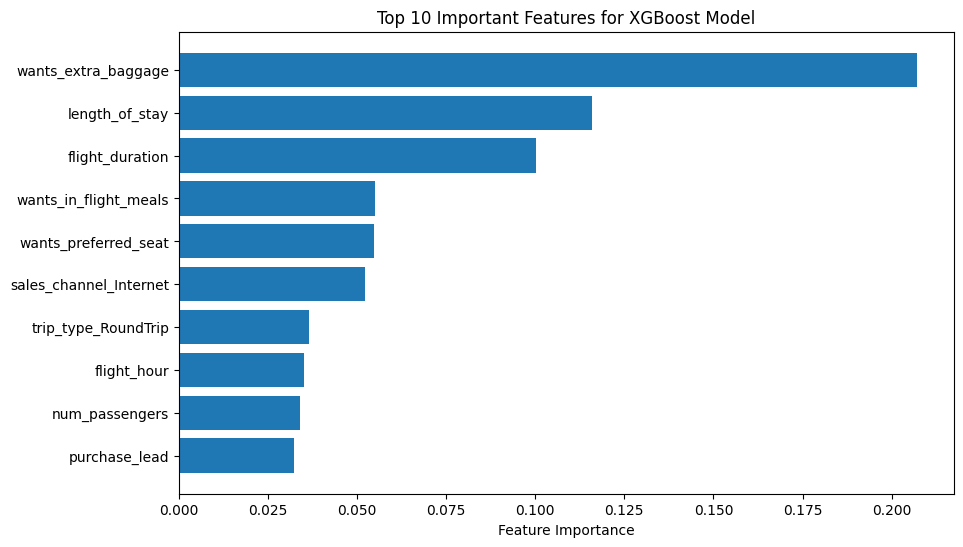

In [13]:
# Plot feature importance for XGBoost
plt.figure(figsize=(10, 6))
xgb_importances = best_xgb_model.feature_importances_
sorted_idx = np.argsort(xgb_importances)[::-1][:10]
plt.barh(range(len(sorted_idx)), xgb_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train.columns[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Top 10 Important Features for XGBoost Model')
plt.gca().invert_yaxis()
plt.show()

## Summary Comparison
- Both models identify length_of_stay as a significant factor, suggesting that how long a customer plans to stay at their destination is crucial for booking decisions.
- The XGBoost model focuses more on amenities and preferences (e.g., baggage, in-flight meals), while the Neural Network model highlights the trip type and specific flight days.
- Sales channels also show up in both models' top features, indicating the impact of how the booking is made, though the specific channels differ.

These findings suggest that personalization, convenience features, trip type, and booking channels are key drivers of booking completions. Understanding these factors can help airlines optimize their offerings and marketing strategies to improve customer conversions.